# CSE440: Natural Language Processing II - Lab Assignment 2

By Fahad Nadim Ziad, 24341216

In [17]:
# Import all required libraries
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import kagglehub  # Dataset download
import string  # Text processing
import matplotlib.pyplot as plt  # Plotting
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF vectorization
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.linear_model import LogisticRegression  # Classification
from sklearn.metrics import f1_score, confusion_matrix, classification_report  # Evaluation
from sklearn.decomposition import PCA  # Dimensionality reduction
from gensim.models import Word2Vec  # Word2Vec training
from gensim.utils import simple_preprocess  # Text preprocessing
from scipy.spatial.distance import cosine  # Similarity calculation
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for clean output

## Task 1: IMDB Sentiment Analysis with TF-IDF and Logistic Regression

In [18]:
# Download and load IMDB dataset
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
data = pd.read_csv(f"{path}/IMDB Dataset.csv")  # Load the dataset

print(f"Dataset shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print("\nFirst few rows:")
print(data.head())

Dataset shape: (50000, 2)
Columns: ['review', 'sentiment']

First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [19]:
# Text preprocessing function with explicit tokenization
def preprocess_text(text):
    """Preprocess text: tokenize, lowercase, remove punctuation"""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize into individual words
    tokens = text.split()  # Split by whitespace to create tokens
    # Join tokens back to string for TF-IDF compatibility
    return ' '.join(tokens)

def tokenize_text(text):
    """Explicit tokenization function to show the tokenization step"""
    # Apply preprocessing first
    preprocessed = preprocess_text(text)
    # Return tokens as list to demonstrate tokenization
    return preprocessed.split()

# Apply preprocessing to reviews
data['processed_review'] = data['review'].apply(preprocess_text)

# Demonstrate tokenization on a sample
sample_tokens = tokenize_text(data['review'].iloc[0])
print(f"Original: {data['review'].iloc[0][:100]}...")
print(f"Processed: {data['processed_review'].iloc[0][:100]}...")
print(f"Tokenized (first 10): {sample_tokens[:10]}")
print(f"Total tokens in sample: {len(sample_tokens)}")

Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
Processed: one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they ...
Tokenized (first 10): ['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching']
Total tokens in sample: 307


In [20]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')  # Limit features for efficiency
X = tfidf.fit_transform(data['processed_review'])  # Transform text to TF-IDF vectors
y = data['sentiment'].map({'positive': 1, 'negative': 0})  # Convert labels to binary

print(f"TF-IDF matrix shape: {X.shape}")
print(f"Feature names (first 10): {tfidf.get_feature_names_out()[:10]}")
print(f"Label distribution: {y.value_counts()}")

TF-IDF matrix shape: (50000, 5000)
Feature names (first 10): ['10' '100' '1010' '11' '110' '12' '13' '13th' '14' '15']
Label distribution: sentiment
1    25000
0    25000
Name: count, dtype: int64


In [21]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # 70-30 split with stratification
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training label distribution: {y_train.value_counts()}")
print(f"Test label distribution: {y_test.value_counts()}")

Training set size: 35000
Test set size: 15000
Training label distribution: sentiment
1    17500
0    17500
Name: count, dtype: int64
Test label distribution: sentiment
0    7500
1    7500
Name: count, dtype: int64


In [22]:
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)  # Increase iterations for convergence
lr_model.fit(X_train, y_train)  # Train the model

# Make predictions
y_pred = lr_model.predict(X_test)  # Predict on test set

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

F1 Score: 0.8893

Confusion Matrix:
[[6565  935]
 [ 747 6753]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      7500
    Positive       0.88      0.90      0.89      7500

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



## Task 2: GloVe Word Embeddings and Analogy Tasks

In [23]:
# Download and load GloVe embeddings
glove_path = kagglehub.dataset_download("danielwillgeorge/glove6b100dtxt")

# Load GloVe embeddings into a dictionary
def load_glove_embeddings(file_path):
    """Load GloVe embeddings from file"""
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]  # First element is the word
            vector = np.array(values[1:], dtype='float32')  # Rest are embedding values
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings(f"{glove_path}/glove.6B.100d.txt")
print(f"Loaded {len(glove_embeddings)} word embeddings")
print(f"Embedding dimension: {len(next(iter(glove_embeddings.values())))}")

Loaded 400000 word embeddings
Embedding dimension: 100


In [24]:
# Analogy task functions
def find_analogy(embeddings, word_a, word_b, word_c, top_n=5):
    """Find word_d using analogy: word_b - word_a + word_c = word_d"""
    if not all(word in embeddings for word in [word_a, word_b, word_c]):
        return "One or more words not found in embeddings"
    
    # Calculate the analogy vector: result = word_b - word_a + word_c
    analogy_vector = embeddings[word_b] - embeddings[word_a] + embeddings[word_c]
    
    # Find most similar words
    similarities = []
    for word, vector in embeddings.items():
        if word not in [word_a, word_b, word_c]:  # Exclude input words
            similarity = 1 - cosine(analogy_vector, vector)  # Cosine similarity
            similarities.append((word, similarity))
    
    # Sort by similarity and return top results
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Test the classic analogy: queen - woman + man = king
result = find_analogy(glove_embeddings, 'woman', 'queen', 'man')
print("Gender Analogy: queen - woman + man")
print("Top 5 similar words:")
for word, similarity in result:
    print(f"{word}: {similarity:.4f}")

# Test geographic analogy
print("\nGeographic Analogy: paris - france + italy")
if all(word in glove_embeddings for word in ['paris', 'france', 'italy']):
    result2 = find_analogy(glove_embeddings, 'france', 'paris', 'italy')
    print("Top 5 similar words:")
    for word, similarity in result2:
        print(f"{word}: {similarity:.4f}")

# Test comparative adjective analogy
print("\nComparative Analogy: better - good + bad")
if all(word in glove_embeddings for word in ['good', 'better', 'bad']):
    result3 = find_analogy(glove_embeddings, 'good', 'better', 'bad')
    print("Top 5 similar words:")
    for word, similarity in result3:
        print(f"{word}: {similarity:.4f}")

Gender Analogy: queen - woman + man
Top 5 similar words:
king: 0.7941
royal: 0.6839
prince: 0.6763
crown: 0.6331
vi: 0.6275

Geographic Analogy: paris - france + italy
Top 5 similar words:
rome: 0.8084
milan: 0.7317
naples: 0.7090
venice: 0.7010
turin: 0.6970

Comparative Analogy: better - good + bad
Top 5 similar words:
rome: 0.8084
milan: 0.7317
naples: 0.7090
venice: 0.7010
turin: 0.6970

Comparative Analogy: better - good + bad
Top 5 similar words:
worse: 0.8393
too: 0.7355
getting: 0.7177
because: 0.7165
even: 0.7159
Top 5 similar words:
worse: 0.8393
too: 0.7355
getting: 0.7177
because: 0.7165
even: 0.7159


## Task 3: Word2Vec Training (CBOW vs Skip-gram) and Evaluation

In [25]:
# Load Reuters corpus and preprocess the text
from nltk.corpus import reuters, stopwords
import nltk

# Download required NLTK data
try:
    # Try to access reuters corpus
    reuters_files = reuters.fileids()
except:
    # Download if not available
    nltk.download('reuters')
    nltk.download('stopwords')
    reuters_files = reuters.fileids()

# Download stopwords if not already present
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

print(f"Reuters corpus: {len(reuters_files)} documents")

# Enhanced preprocessing function for Reuters
def preprocess_reuters_text(text):
    """Tokenize text, convert to lowercase, and remove stop words"""
    tokens = simple_preprocess(text, min_len=2, max_len=15)  # Tokenize and filter length
    # Convert to lowercase (already done by simple_preprocess) and remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return filtered_tokens

# Load and preprocess Reuters corpus
corpus = []
for file_id in reuters_files:
    # Get raw text from each Reuters document
    text = reuters.raw(file_id)
    # Preprocess the text
    processed_text = preprocess_reuters_text(text)
    if len(processed_text) > 5:  # Only include documents with sufficient content
        corpus.append(processed_text)

print(f"Processed corpus: {len(corpus)} documents")

# Calculate vocabulary statistics
all_words = [word for doc in corpus for word in doc]
word_freq = pd.Series(all_words).value_counts()
print(f"Total tokens: {len(all_words)}")
print(f"Unique words: {len(word_freq)}")
print(f"Most frequent words: {word_freq.head()}")

Reuters corpus: 10788 documents
Processed corpus: 10727 documents
Total tokens: 830708
Unique words: 28638
Most frequent words: said    25383
mln     18623
dlrs    12417
pct      9810
cts      8361
Name: count, dtype: int64
Processed corpus: 10727 documents
Total tokens: 830708
Unique words: 28638
Most frequent words: said    25383
mln     18623
dlrs    12417
pct      9810
cts      8361
Name: count, dtype: int64


In [26]:
# Train Word2Vec models - CBOW and Skip-gram
# CBOW model (sg=0)
cbow_model = Word2Vec(
    sentences=corpus,
    vector_size=100,  # Embedding dimension
    window=5,         # Context window size
    min_count=5,      # Minimum word frequency
    sg=0,             # 0 = CBOW, 1 = Skip-gram
    epochs=10,        # Training iterations
    seed=42           # Set seed for reproducibility
)

# Skip-gram model (sg=1)
skipgram_model = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    sg=1,             # Skip-gram
    epochs=10,
    seed=42           # Set seed for reproducibility
)

print(f"CBOW vocabulary size: {len(cbow_model.wv)}")
print(f"Skip-gram vocabulary size: {len(skipgram_model.wv)}")

CBOW vocabulary size: 10128
Skip-gram vocabulary size: 10128


In [27]:
# Evaluate Word2Vec models on analogy tasks
def test_word2vec_analogy(model, word_a, word_b, word_c, model_name):
    """Test analogy with Word2Vec model using format: word_b - word_a + word_c = ?"""
    try:
        # Use gensim's built-in analogy function
        result = model.wv.most_similar(positive=[word_b, word_c], negative=[word_a], topn=5)
        print(f"\n{model_name} - Analogy: {word_b} - {word_a} + {word_c} = ?")
        for word, similarity in result:
            print(f"{word}: {similarity:.4f}")
        return result
    except KeyError as e:
        print(f"{model_name} - Word not found: {e}")
        return None

# Test Reuters-appropriate analogies
print("Financial/Business Analogies:")

# Business relationship analogy
print("\n1. Size-Profit Relationship: large - small + profit")
test_word2vec_analogy(cbow_model, 'small', 'large', 'profit', 'CBOW')
test_word2vec_analogy(skipgram_model, 'small', 'large', 'profit', 'Skip-gram')

# Market action analogy
print("\n2. Market Action Relationship: sell - buy + gain")
test_word2vec_analogy(cbow_model, 'buy', 'sell', 'gain', 'CBOW')
test_word2vec_analogy(skipgram_model, 'buy', 'sell', 'gain', 'Skip-gram')

# Time-based financial analogy
if 'year' in cbow_model.wv and 'annual' in cbow_model.wv and 'month' in cbow_model.wv:
    print("\n3. Time Period Relationship: annual - year + month")
    test_word2vec_analogy(cbow_model, 'year', 'annual', 'month', 'CBOW')
    test_word2vec_analogy(skipgram_model, 'year', 'annual', 'month', 'Skip-gram')

# Test word similarity on financial terms
print("\nWord Similarity Results:")
if 'company' in cbow_model.wv and 'corporation' in cbow_model.wv:
    print(f"CBOW similarity (company vs corporation): {cbow_model.wv.similarity('company', 'corporation'):.4f}")
    print(f"Skip-gram similarity (company vs corporation): {skipgram_model.wv.similarity('company', 'corporation'):.4f}")

if 'profit' in cbow_model.wv and 'loss' in cbow_model.wv:
    print(f"CBOW similarity (profit vs loss): {cbow_model.wv.similarity('profit', 'loss'):.4f}")
    print(f"Skip-gram similarity (profit vs loss): {skipgram_model.wv.similarity('profit', 'loss'):.4f}")

Financial/Business Analogies:

1. Size-Profit Relationship: large - small + profit

CBOW - Analogy: large - small + profit = ?
loss: 0.6850
turnover: 0.5730
schillings: 0.5723
net: 0.5692
rand: 0.5683

Skip-gram - Analogy: large - small + profit = ?
avg: 0.6415
net: 0.6238
swissair: 0.6167
qtrs: 0.6151
restated: 0.5913

2. Market Action Relationship: sell - buy + gain

CBOW - Analogy: sell - buy + gain = ?
charge: 0.7084
gains: 0.6848
extraordinary: 0.6464
disposal: 0.6461
discontinued: 0.6362

Skip-gram - Analogy: sell - buy + gain = ?
nonrecurring: 0.5924
disposition: 0.5838
charge: 0.5807
gains: 0.5789
carryforward: 0.5770

3. Time Period Relationship: annual - year + month

CBOW - Analogy: annual - year + month = ?
distributed: 0.5003
emergency: 0.4849
special: 0.4682
tomorrow: 0.4648
tuesday: 0.4630

Skip-gram - Analogy: annual - year + month = ?
cabinet: 0.5132
regularly: 0.4585
dissolution: 0.4394
finished: 0.4249
fortnightly: 0.4245

Word Similarity Results:
CBOW similarity (co

In [28]:
# Select 30 most frequent words from the corpus
top_30_words = word_freq.head(30).index.tolist()  # Get top 30 frequent words
print("Top 30 most frequent words:")
print(top_30_words)

# Filter words that exist in both models
common_words = [word for word in top_30_words 
                if word in cbow_model.wv and word in skipgram_model.wv]
print(f"\nWords available in both models: {len(common_words)}")
print(common_words[:15])

Top 30 most frequent words:
['said', 'mln', 'dlrs', 'pct', 'cts', 'year', 'net', 'billion', 'loss', 'would', 'company', 'shr', 'inc', 'bank', 'corp', 'oil', 'last', 'share', 'trade', 'one', 'profit', 'market', 'new', 'qtr', 'two', 'shares', 'stock', 'also', 'tonnes', 'revs']

Words available in both models: 30
['said', 'mln', 'dlrs', 'pct', 'cts', 'year', 'net', 'billion', 'loss', 'would', 'company', 'shr', 'inc', 'bank', 'corp']


Individual Model Visualizations:


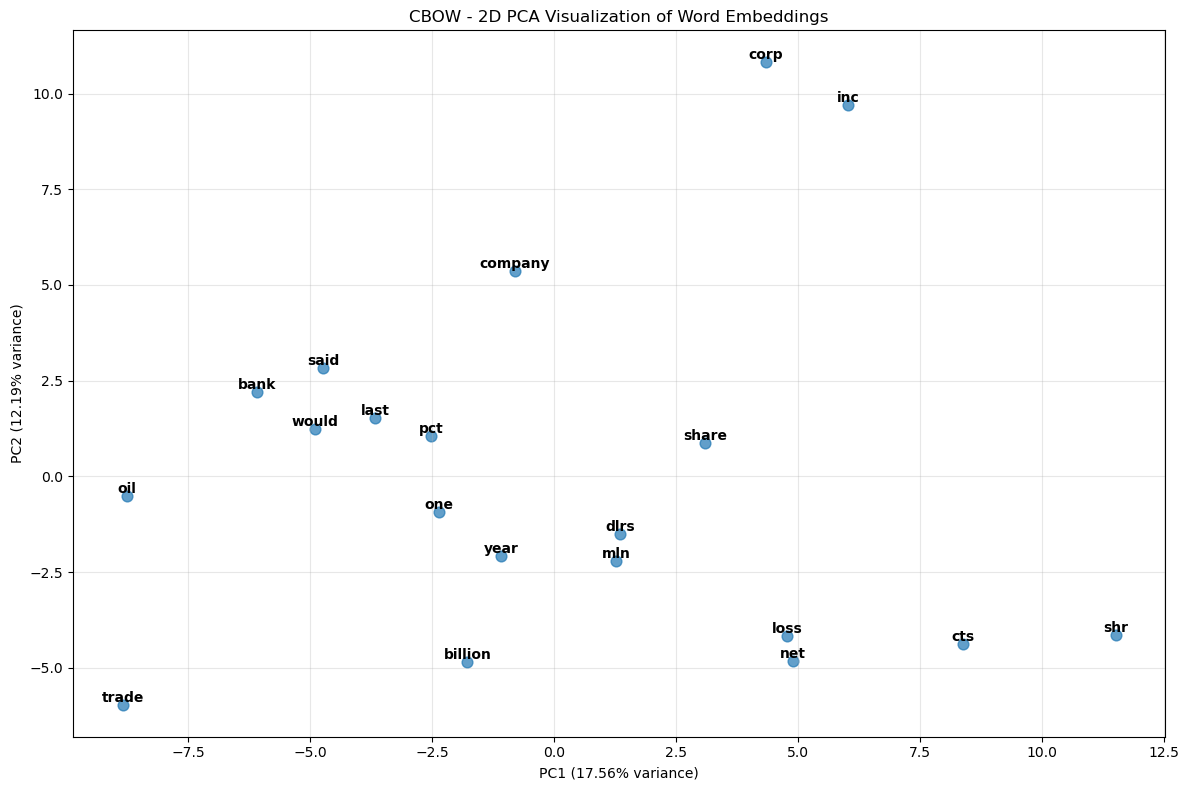

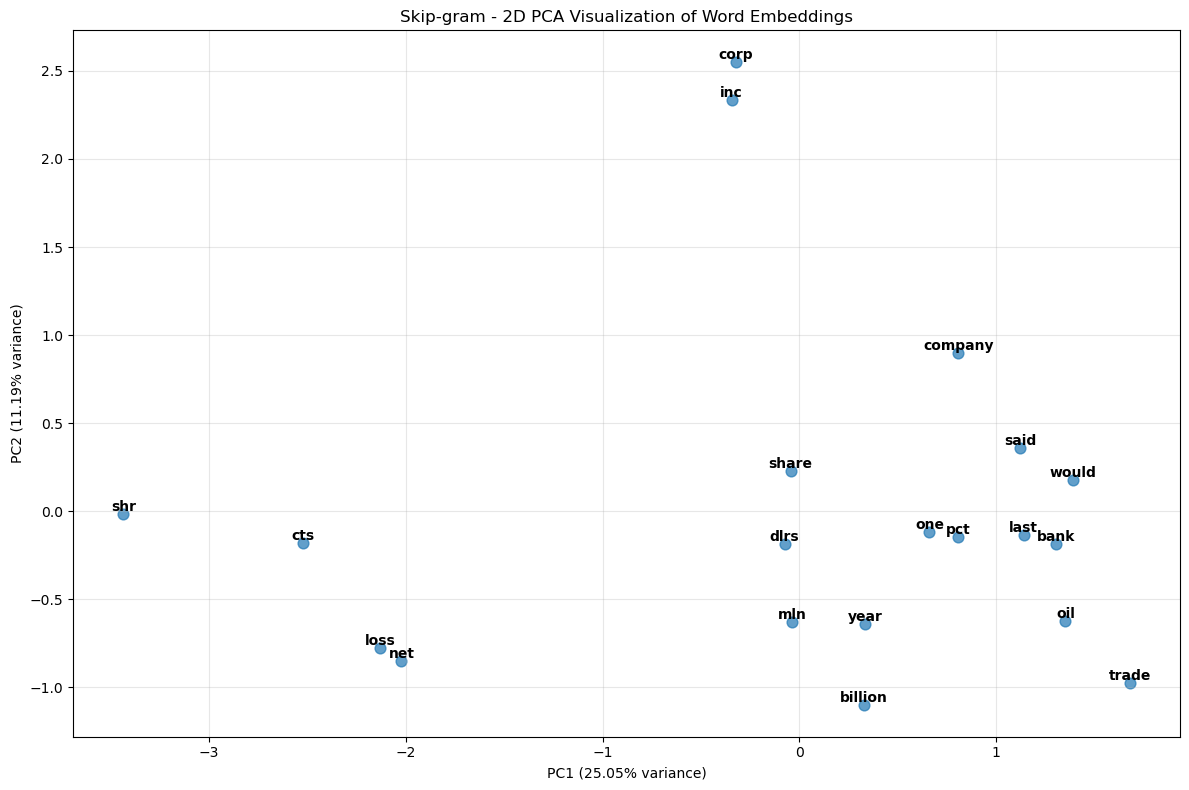


Side-by-Side Model Comparison:


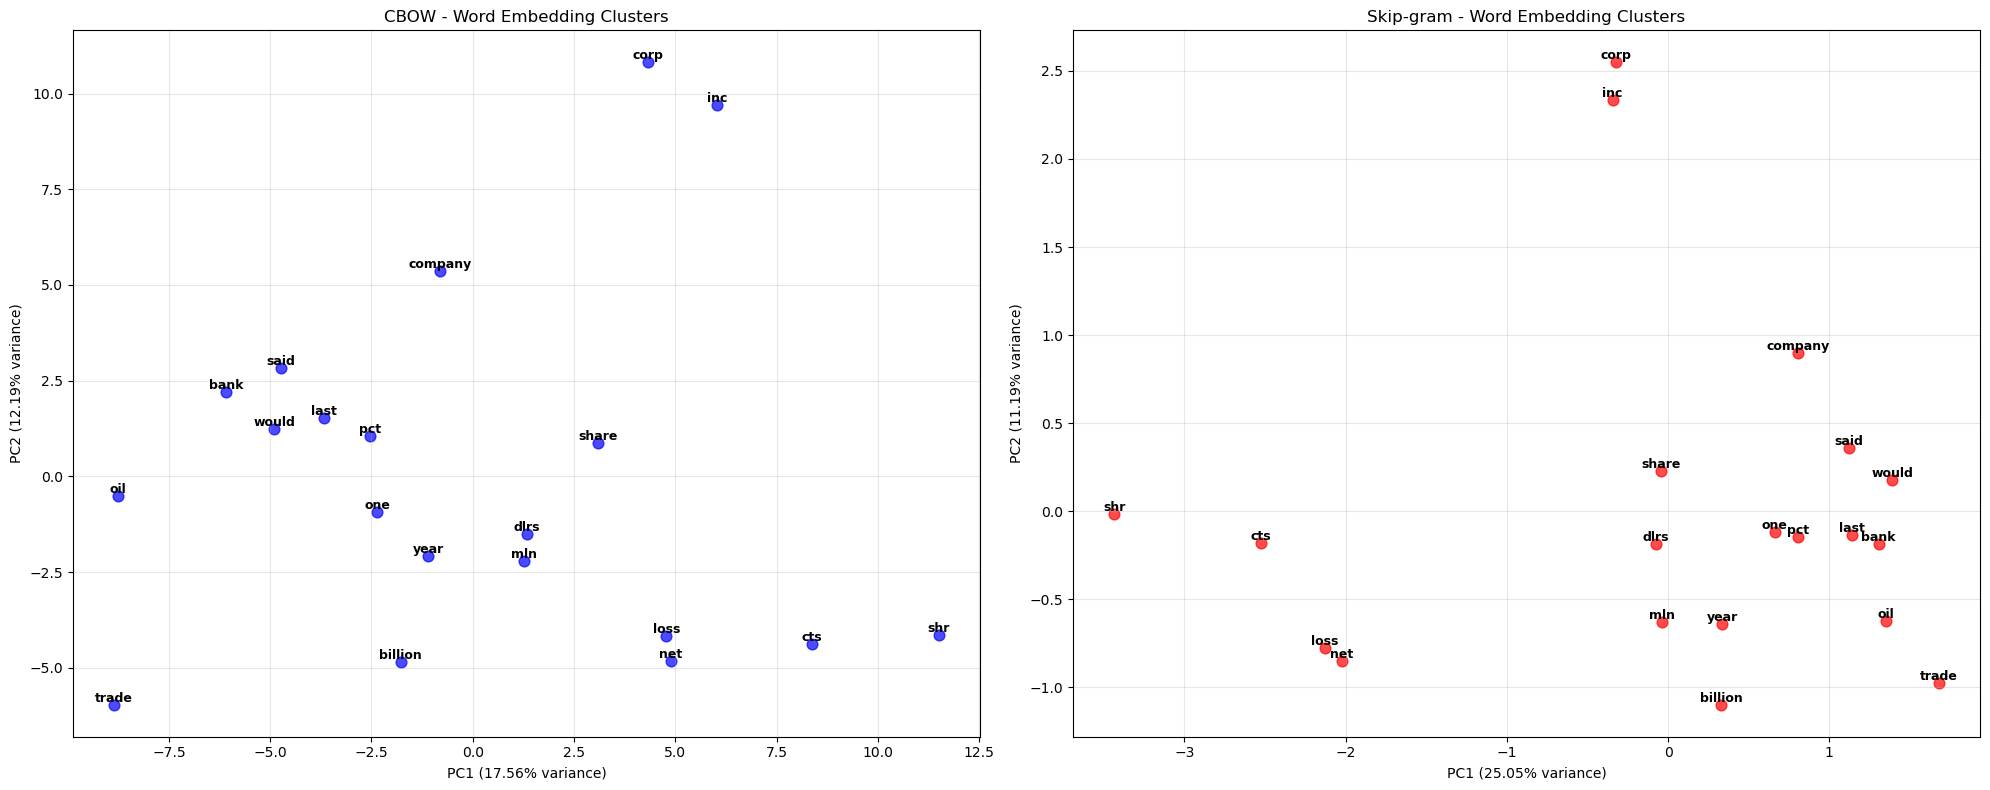

In [29]:
# Apply PCA for dimensionality reduction and visualization
def plot_word_embeddings(model, words, model_name):
    """Plot 2D visualization of word embeddings using PCA with labeled points"""
    # Get embeddings for the words
    embeddings = np.array([model.wv[word] for word in words])
    
    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2, random_state=42)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, s=60)
    
    # Add word labels for each point to observe clusters
    for i, word in enumerate(words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                    fontsize=10, ha='center', va='bottom', fontweight='bold')
    
    plt.title(f'{model_name} - 2D PCA Visualization of Word Embeddings')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d, pca

def plot_model_comparison(cbow_model, skipgram_model, words):
    """Side-by-side comparison of CBOW and Skip-gram embeddings"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # CBOW visualization
    cbow_embeddings = np.array([cbow_model.wv[word] for word in words])
    pca_cbow = PCA(n_components=2, random_state=42)
    cbow_2d = pca_cbow.fit_transform(cbow_embeddings)
    
    ax1.scatter(cbow_2d[:, 0], cbow_2d[:, 1], alpha=0.7, s=60, c='blue')
    for i, word in enumerate(words):
        ax1.annotate(word, (cbow_2d[i, 0], cbow_2d[i, 1]), 
                    fontsize=9, ha='center', va='bottom', fontweight='bold')
    ax1.set_title('CBOW - Word Embedding Clusters')
    ax1.set_xlabel(f'PC1 ({pca_cbow.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca_cbow.explained_variance_ratio_[1]:.2%} variance)')
    ax1.grid(True, alpha=0.3)
    
    # Skip-gram visualization
    skipgram_embeddings = np.array([skipgram_model.wv[word] for word in words])
    pca_skipgram = PCA(n_components=2, random_state=42)
    skipgram_2d = pca_skipgram.fit_transform(skipgram_embeddings)
    
    ax2.scatter(skipgram_2d[:, 0], skipgram_2d[:, 1], alpha=0.7, s=60, c='red')
    for i, word in enumerate(words):
        ax2.annotate(word, (skipgram_2d[i, 0], skipgram_2d[i, 1]), 
                    fontsize=9, ha='center', va='bottom', fontweight='bold')
    ax2.set_title('Skip-gram - Word Embedding Clusters')
    ax2.set_xlabel(f'PC1 ({pca_skipgram.explained_variance_ratio_[0]:.2%} variance)')
    ax2.set_ylabel(f'PC2 ({pca_skipgram.explained_variance_ratio_[1]:.2%} variance)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return cbow_2d, skipgram_2d

# Use top 20 words for better visualization
viz_words = common_words[:20]

# Individual model visualizations with labeled points
print("Individual Model Visualizations:")
cbow_2d, pca_cbow = plot_word_embeddings(cbow_model, viz_words, 'CBOW')
skipgram_2d, pca_skipgram = plot_word_embeddings(skipgram_model, viz_words, 'Skip-gram')

# Side-by-side comparison
print("\nSide-by-Side Model Comparison:")
cbow_comparison, skipgram_comparison = plot_model_comparison(cbow_model, skipgram_model, viz_words)

In [30]:
# Cluster Analysis and Model Comparison
def analyze_clusters(words, embeddings_2d, model_name):
    """Analyze semantic clusters in 2D embedding space"""
    print(f"\n{model_name} Cluster Analysis:")
    
    # Calculate pairwise distances to identify close words
    from scipy.spatial.distance import pdist, squareform
    distances = squareform(pdist(embeddings_2d, metric='euclidean'))
    
    # Find closest word pairs (semantic clusters)
    close_pairs = []
    for i in range(len(words)):
        for j in range(i+1, len(words)):
            if distances[i, j] < np.percentile(distances, 20):  # Bottom 20% of distances
                close_pairs.append((words[i], words[j], distances[i, j]))
    
    # Sort by distance
    close_pairs.sort(key=lambda x: x[2])
    
    print("Closest word pairs (potential semantic clusters):")
    for word1, word2, dist in close_pairs[:5]:
        print(f"  {word1} - {word2}: {dist:.3f}")
    
    return close_pairs

# Analyze clusters for both models
print("SEMANTIC CLUSTER ANALYSIS")
print("=" * 50)

# Analyze CBOW clusters
cbow_clusters = analyze_clusters(viz_words, cbow_2d, "CBOW")

# Analyze Skip-gram clusters  
skipgram_clusters = analyze_clusters(viz_words, skipgram_2d, "Skip-gram")

# Compare clustering patterns
print(f"\nCOMPARISON ANALYSIS:")
print("=" * 30)
print(f"Number of close pairs (CBOW): {len(cbow_clusters)}")
print(f"Number of close pairs (Skip-gram): {len(skipgram_clusters)}")

# Find common clusters between models
cbow_pairs = {(min(pair[0], pair[1]), max(pair[0], pair[1])) for pair in cbow_clusters}
skipgram_pairs = {(min(pair[0], pair[1]), max(pair[0], pair[1])) for pair in skipgram_clusters}
common_clusters = cbow_pairs.intersection(skipgram_pairs)

print(f"Common clusters between models: {len(common_clusters)}")
if common_clusters:
    print("Shared semantic groupings:")
    for pair in list(common_clusters)[:3]:
        print(f"  {pair[0]} - {pair[1]}")

print(f"\nModel-specific clusters:")
print(f"CBOW unique: {len(cbow_pairs - skipgram_pairs)}")
print(f"Skip-gram unique: {len(skipgram_pairs - cbow_pairs)}")

SEMANTIC CLUSTER ANALYSIS

CBOW Cluster Analysis:
Closest word pairs (potential semantic clusters):
  net - loss: 0.657
  mln - dlrs: 0.699
  pct - last: 1.237
  would - last: 1.265
  said - bank: 1.483

Skip-gram Cluster Analysis:
Closest word pairs (potential semantic clusters):
  net - loss: 0.129
  pct - one: 0.150
  bank - last: 0.174
  inc - corp: 0.212
  said - would: 0.322

COMPARISON ANALYSIS:
Number of close pairs (CBOW): 30
Number of close pairs (Skip-gram): 30
Common clusters between models: 23
Shared semantic groupings:
  dlrs - share
  bank - said
  corp - inc

Model-specific clusters:
CBOW unique: 7
Skip-gram unique: 7


In [31]:
# Compare CBOW vs Skip-gram models
print("MODEL COMPARISON SUMMARY")
print(f"CBOW Model:")
print(f"  - Vocabulary size: {len(cbow_model.wv)}")
print(f"  - Vector dimension: {cbow_model.wv.vector_size}")

print(f"\nSkip-gram Model:")
print(f"  - Vocabulary size: {len(skipgram_model.wv)}")
print(f"  - Vector dimension: {skipgram_model.wv.vector_size}")

print("\nModel Characteristics:")
print("- CBOW: Better for frequent words, faster training")
print("- Skip-gram: Better for rare words, captures more semantic relationships")

# Sample word similarities for comparison
test_words = ['good', 'bad', 'movie', 'film']
available_test_words = [w for w in test_words if w in cbow_model.wv and w in skipgram_model.wv]

if len(available_test_words) >= 2:
    word1, word2 = available_test_words[0], available_test_words[1]
    print(f"\nSimilarity between '{word1}' and '{word2}':")
    print(f"CBOW: {cbow_model.wv.similarity(word1, word2):.4f}")
    print(f"Skip-gram: {skipgram_model.wv.similarity(word1, word2):.4f}")

MODEL COMPARISON SUMMARY
CBOW Model:
  - Vocabulary size: 10128
  - Vector dimension: 100

Skip-gram Model:
  - Vocabulary size: 10128
  - Vector dimension: 100

Model Characteristics:
- CBOW: Better for frequent words, faster training
- Skip-gram: Better for rare words, captures more semantic relationships

Similarity between 'good' and 'bad':
CBOW: 0.4368
Skip-gram: 0.4300
